<a href="https://colab.research.google.com/github/Ad450/llm-interpretability/blob/main/distilbert_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
pip install torch transformers bitsandbytes scipy matplotlib seaborn


In [29]:
MODEL_NAME = "distilbert-base-uncased"

In [30]:
text = "The patient was not diagnosed with cancer."

In [31]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
inputs = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])


In [32]:
from transformers import AutoModel

model_fp32 = AutoModel.from_pretrained(
    MODEL_NAME,
    output_attentions=True
)

model_fp32.eval()


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [33]:
import torch

with torch.no_grad():
    outputs_fp32 = model_fp32(**inputs)


In [34]:
attentions_fp32 = outputs_fp32.attentions
print(attentions_fp32)

(tensor([[[[5.0229e-02, 9.4302e-02, 7.5057e-02,  ..., 7.4842e-02,
           1.8535e-01, 2.1484e-01],
          [2.6647e-01, 7.6810e-02, 6.9645e-02,  ..., 7.1982e-02,
           7.1411e-02, 8.8444e-02],
          [1.5811e-01, 2.0189e-02, 2.1330e-01,  ..., 1.2321e-01,
           4.2181e-02, 8.6788e-02],
          ...,
          [9.7155e-02, 2.5299e-02, 2.5983e-01,  ..., 9.7163e-02,
           7.0669e-02, 7.6098e-02],
          [2.4651e-01, 9.2639e-02, 5.3153e-02,  ..., 5.3915e-02,
           1.2924e-01, 1.1099e-01],
          [1.5986e-01, 1.1703e-01, 4.5569e-02,  ..., 7.8364e-02,
           7.8975e-02, 2.3737e-01]],

         [[9.5490e-01, 1.1628e-02, 2.9713e-03,  ..., 2.1498e-03,
           4.5147e-03, 5.8297e-03],
          [1.0790e-02, 9.7909e-02, 4.2406e-02,  ..., 8.0358e-02,
           6.5838e-02, 4.3007e-02],
          [1.5781e-02, 2.0252e-02, 8.1184e-02,  ..., 5.3980e-01,
           8.9252e-03, 1.5670e-01],
          ...,
          [1.3680e-02, 1.5898e-01, 1.1900e-01,  ..., 4.840

In [35]:
import torch

# last layer
last_layer_attn = attentions_fp32[-1][0]  # shape: (heads, seq, seq)

# average across heads
avg_attn_fp32 = last_layer_attn.mean(dim=0)  # (seq, seq)

# choose query token index
query_token = tokens.index("diagnosed")  # or any token you want

attention_vector_fp32 = avg_attn_fp32[query_token].cpu().numpy()

print(attention_vector_fp32)


[0.03282262 0.03102453 0.02916156 0.0301333  0.03356839 0.0402159
 0.03033196 0.0463482  0.55918425 0.16720931]


In [36]:
import torch.quantization

model_int8 = AutoModel.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,
    output_attentions=True,
    device_map="auto"
)
print(f"........... here is the quantised model {model_int8}")
model_int8.eval()


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


........... here is the quantised model DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          (k_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          (v_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          (out_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear8bit

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          (k_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          (v_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          (out_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear8bitLt(in_features=768, out_features=3072, b

In [37]:
with torch.no_grad():
    outputs_int8 = model_int8(**inputs)


In [38]:
attentions_int8 = outputs_int8.attentions
last_layer_attn = attentions_int8[-1][0]
avg_attn_int8 = last_layer_attn.mean(dim=0)
attention_vector_int8 = avg_attn_int8[query_token].cpu().numpy()

print(attention_vector_int8)

[0.0316  0.03226 0.02922 0.0297  0.03308 0.0394  0.02914 0.04468 0.564
 0.1671 ]


In [39]:
from transformers import AutoModel
import bitsandbytes as bnb

model_int4 = AutoModel.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    output_attentions=True,
    device_map="auto"
)
print(f"........... here is the quantised model {model_int4}")
model_int4.eval()


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


........... here is the quantised model DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          (k_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          (v_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          (out_lin): Linear4bit(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear4bit(in_feat

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          (k_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          (v_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          (out_lin): Linear4bit(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear4bit(in_features=768, out_features=3072, bias=True)


In [ ]:
inputs_gpu = {k: v.to(model_int4.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs_int4 = model_int4(**inputs_gpu)


In [ ]:
attentions_int4 = outputs_int4.attentions
last_layer_attn = attentions_int4[-1][0]
avg_attn_int4 = last_layer_attn.mean(dim=0)
attention_vector_int4 = avg_attn_int4[query_token].cpu().numpy()

print(attention_vector_int4)

In [ ]:
from scipy.stats import spearmanr

rho_int8, _ = spearmanr(attention_vector_fp32, attention_vector_int8)
rho_int4, _ = spearmanr(attention_vector_fp32, attention_vector_int4)

print("FP32 vs INT8:", rho_int8)
print("FP32 vs INT4:", rho_int4)


In [ ]:
import numpy as np

def topk_overlap(a, b, k=3):
    return len(set(np.argsort(a)[-k:]) & set(np.argsort(b)[-k:])) / k

print("Top-k INT8:", topk_overlap(attention_vector_fp32, attention_vector_int8))
print("Top-k INT4:", topk_overlap(attention_vector_fp32, attention_vector_int4))


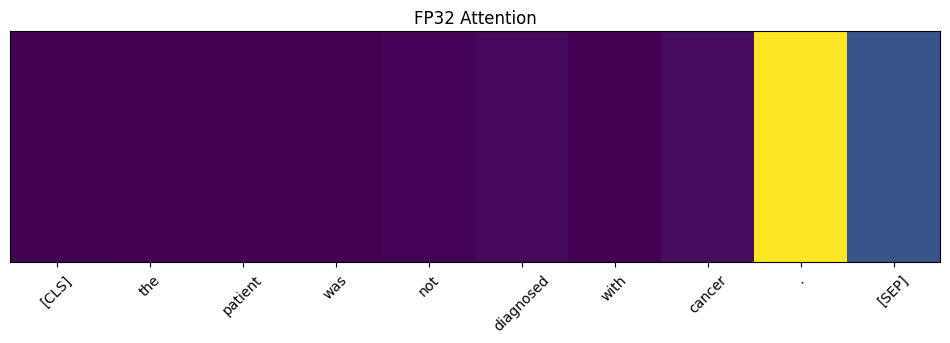

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.imshow([attention_vector_fp32], aspect="auto")
plt.yticks([])
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.title("FP32 Attention")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.imshow([attention_vector_int8], aspect="auto")
plt.yticks([])
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.title("int8 Attention")
plt.show()


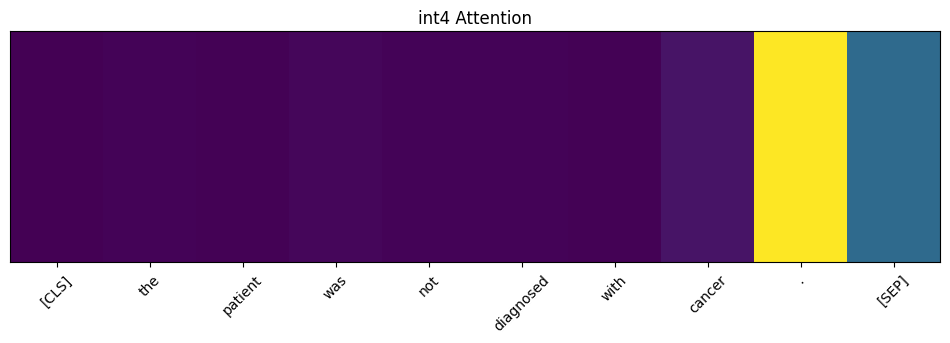

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.imshow([attention_vector_int4], aspect="auto")
plt.yticks([])
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.title("int4 Attention")
plt.show()


In [42]:
#### Reruning experiments with GPT- 2

In [43]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config

# Load tokenizer & model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Load GPT-2 config
config = GPT2Config.from_pretrained("gpt2")
config.attn_implementation = "eager"   # <- change attention mode
config.output_attentions = True        # <- enable attention outputs

# Load GPT-2 model with config
model_fp32_gpt = GPT2Model.from_pretrained("gpt2", config=config)
model_fp32_gpt.eval()


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

In [ ]:
model_fp32_gpt.eval()
model_fp32_gpt.config.output_attentions = True

with torch.no_grad():
    outputs = model_fp32_gpt(**inputs)
    attentions_fp32_gpt = outputs.attentions  # tuple: one tensor per layer


In [45]:
import torch
from transformers import BitsAndBytesConfig

# Load tokenizer & model

bnb_int8_config = BitsAndBytesConfig(
    load_in_8bit=True
)

model_int8_gpt = GPT2Model.from_pretrained(
    "gpt2",
    quantization_config=bnb_int8_config,
    attn_implementation="eager",
    output_attentions=True
)

model_int8_gpt.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Linear8bitLt(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear8bitLt(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Linear8bitLt(in_features=768, out_features=3072, bias=True)
        (c_proj): Linear8bitLt(in_features=3072, out_features=768, bias=True)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [46]:
from transformers import BitsAndBytesConfig
from transformers import GPT2Model

config.output_attentions = True
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model_int4_gpt = GPT2Model.from_pretrained("gpt2", quantization_config=bnb_config, attn_implementation="eager")
model_int4_gpt.eval()


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
        (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [48]:
def get_attentions(model, input_ids, attention_mask):
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions  # tuple: (num_layers, batch, heads, seq_len, seq_len)
    return attentions

In [49]:
# with torch.no_grad():
#     outputs_int8 = model_int8_gpt(input_ids, attention_mask=attention_mask, output_attentions=True)
#     att_int8 = outputs_int8.attentions

# with torch.no_grad():
#     outputs_int4 = model_int4_gpt(input_ids, attention_mask=attention_mask, output_attentions=True)
#     att_int4 = outputs_int4.attentions

att_fp32 = get_attentions(model_fp32_gpt, input_ids, attention_mask)
att_int8 = get_attentions(model_int8_gpt, input_ids, attention_mask)
att_int4 = get_attentions(model_int4_gpt, input_ids, attention_mask)

print(att_int8)

(tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [8.7256e-01, 1.2732e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [4.5898e-01, 2.4915e-01, 2.9175e-01, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.1221e-01, 2.3376e-01, 1.7114e-01, 8.2703e-02, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.4573e-01, 4.3701e-01, 1.0272e-01, 4.5563e-02, 1.6919e-01,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [4.0039e-01, 1.5759e-01, 1.3904e-01, 8.0322e-02, 1.7664e-01,
           4.5959e-02, 0.0000e+00, 0.0000e+00],
          [4.1919e-01, 8.7830e-02, 8.8135e-02, 6.2866e-02, 4.2267e-02,
           1.1230e-01, 1.8750e-01, 0.0000e+00],
          [5.1953e-01, 1.2183e-01, 8.6914e-02, 7.7881e-02, 8.4045e-02,
           3.5522e-02, 5.4688e-02, 1.9623e-02]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00

In [47]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def analyze_token(
    att_fp32,
    att_quant,
    token_index,
    k=3,
    layer=-1,
    head=0,
    eps=1e-8
):
    # Extract attention vectors
    fp32_vec = att_fp32[layer][0, :, token_index, :].mean(0).cpu().numpy()
    quant_vec = att_quant[layer][0, :, token_index, :].mean(0).cpu().numpy()
    # -------- Pearson correlation (value fidelity)
    pearson = np.corrcoef(fp32_vec, quant_vec)[0, 1]

    # -------- Mean errors
    mae = np.mean(np.abs(fp32_vec - quant_vec))
    mse = np.mean((fp32_vec - quant_vec) ** 2)

    # -------- Jensen–Shannon divergence (distribution shift)
    fp32_prob = fp32_vec + eps
    quant_prob = quant_vec + eps

    fp32_prob /= fp32_prob.sum()
    quant_prob /= quant_prob.sum()

    # jensenshannon returns sqrt(JS); square it for true JS divergence
    js_div = jensenshannon(fp32_prob, quant_prob) ** 2

    # -------- Top-k overlap (ranking fidelity)
    topk_fp32 = set(fp32_vec.argsort()[-k:])
    topk_quant = set(quant_vec.argsort()[-k:])
    topk_overlap = len(topk_fp32 & topk_quant) / k

    return {
        "pearson": pearson,
        "mae": mae,
        "mse": mse,
        "js": js_div,
        "topk": topk_overlap
    }



In [50]:
# Map words → token indices (after BPE)
tokens = tokenizer.tokenize(text)


# Example: choose 'patient', 'diagnosed', 'was'
token_indices = [i for i, t in enumerate(tokens) if t in {"Ġpatient", "Ġwas", "Ġdiagnosed"}]

results = []
for idx in token_indices:

    fp32_int8 = analyze_token(att_fp32, att_int8, idx)

    fp32_int4 = analyze_token(att_fp32, att_int4, idx)

    results.append({
        tokens[idx] : [ {"fp32_int8": fp32_int8,"fp32_int4":fp32_int4} ]
    })


print(results)


[{'Ġpatient': [{'fp32_int8': {'pearson': np.float64(0.9999989499331954), 'mae': np.float32(0.0002543535), 'mse': np.float32(2.5878282e-07), 'js': np.float32(1.0198708e-06), 'topk': 1.0}, 'fp32_int4': {'pearson': np.float64(0.9999567388135451), 'mae': np.float32(0.0016123857), 'mse': np.float32(1.0400083e-05), 'js': np.float32(3.8960552e-05), 'topk': 1.0}}]}, {'Ġwas': [{'fp32_int8': {'pearson': np.float64(0.9999975121500175), 'mae': np.float32(0.00034486596), 'mse': np.float32(3.6436055e-07), 'js': np.float32(2.568131e-06), 'topk': 1.0}, 'fp32_int4': {'pearson': np.float64(0.9997982650103432), 'mae': np.float32(0.0031570261), 'mse': np.float32(3.075342e-05), 'js': np.float32(0.00019130237), 'topk': 1.0}}]}, {'Ġdiagnosed': [{'fp32_int8': {'pearson': np.float64(0.9999889027822487), 'mae': np.float32(0.0012273015), 'mse': np.float32(3.0064857e-06), 'js': np.float32(2.4059553e-05), 'topk': 1.0}, 'fp32_int4': {'pearson': np.float64(0.9997939097879635), 'mae': np.float32(0.0065352125), 'mse':